## Exploratoy Data Analysis/More Cleaning

NOTE: Before concating the dataframes, it is necessary to add a 'timeleft' columns to anything scraped from ebay's 'completed sales'.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import re
%matplotlib inline

In [4]:
active_sales = pd.read_csv('./old cleaned:used datasets /cleaned_csv_3_1', index_col=0)
active_sales_2 = pd.read_csv('./old cleaned:used datasets /cleaned_csv_3_8', index_col=0)
active_sales_3 = pd.read_csv('./cleaned_csv_3_17', index_col=0)
completed_sales = pd.read_csv('./old cleaned:used datasets /cleaned_completed_3_4', index_col=0)
completed_sales_2 = pd.read_csv('./cleaned_completed_3_17', index_col=0)

In [5]:
active_sales = pd.concat([active_sales, active_sales_2, active_sales_3], axis=0).reset_index(drop=True)

In [6]:
#8851 duplicates dropped

active_sales = active_sales.drop(list(active_sales[active_sales.duplicated(
    subset='itemId', keep='last')].index), axis=0)

In [7]:
completed_sales = pd.concat([completed_sales, completed_sales_2], axis=0).reset_index(drop=True)

In [8]:
completed_sales = completed_sales.drop(list(completed_sales[completed_sales.duplicated(
    subset='itemId', keep='last')].index), axis=0)

In [9]:
#adding timeLeft column to completed sales, with 0 value
completed_sales['timeLeft'] = pd.Timedelta(0)

In [10]:
#fixing time deltas
deltas = []
for val in active_sales['timeLeft']:
    time = val[:-10]
    deltas.append(pd.Timedelta(time))

active_sales['timeLeft'] = deltas

In [11]:
#merged dataframe
df = pd.concat([active_sales, completed_sales], axis=0).reset_index(drop=True)

In [12]:
#dropping additional duplicates after merge (first run found 300)
df = df.drop(list(df[df.duplicated(
    subset='itemId', keep='last')].index), axis = 0)

In [13]:
#turning timeLeft into an float variable representing number of hours remaining
df['timeLeft'] = df['timeLeft'] / pd.Timedelta(hours=1)


#turning hours into categorical variables
df['timeLeft'] = pd.cut(df['timeLeft'], 
               [0, 1, 6, 24, 48, 168, df['timeLeft'].max()], 
                labels=['less_than_hour_left', 'less_than_6hours_left', 
                  'less_than_day_left', 'less_than_2day_left', 'less_than_week_left',
                  'more_than_week_left'])
df['timeLeft'] = df['timeLeft'].astype(object).fillna('completed_no_time_left')

#then into dummies

df = pd.concat([df, pd.get_dummies(df['timeLeft']).drop('more_than_week_left', 
                                                        axis=1)], axis=1)
df = df.drop('timeLeft', axis=1)

In [14]:
#dropping roman coin jewelry categories

df = df.drop(list(df.loc[df['categoryId'] == 137843].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 164343].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 548].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 164341].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 45157].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 29223].index), axis=0)
df = df.drop(list(df.loc[df['categoryId'] == 13993].index), axis=0)

#dropping additional categories likely not to be individual coins
drop_cols = df['categoryId'].value_counts().reset_index()
val_to_drop = list(drop_cols.loc[drop_cols['categoryId'] < 12]['index'])
df = df.drop(df[df['categoryId'].isin(val_to_drop)].index, axis=0)

In [15]:
#dropping sales not in USD
df = df.drop(list(df[df['current_currency'] != 'USD'].index), axis=0)

#all USD, dropping
df = df.drop('currencyid_conv', axis=1)

#dropping title, URLTitle slightly more effective, nearly identical 
df = df.drop('title', axis=1)

#all USD
df = df.drop('current_currency', axis=1)

#already have dummy variable
df = df.drop('buyItNowPrice', axis=1)

In [16]:
#Creating dummy for if the sale is in the USA
df['seller_in_us'] = df['country'].apply(lambda x: 1 if x == 'US' else 0)
df = df.drop('country', axis=1)

In [17]:
#Converting to datetime 
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

In [18]:
#Should be zero now
print(df.loc[df.duplicated()].shape)
df = df.drop_duplicates()

(0, 31)


In [19]:
#3036 of the 14856 sales are auctions 
df.loc[df['listingType'] =='Auction'].shape

(5335, 31)

Text(0.5,0,'Number of Bids in Auctions')

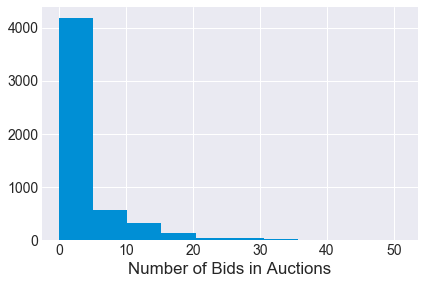

In [20]:
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
df.loc[df['listingType'] =='Auction']['bidCount'].hist()
plt.xlabel('Number of Bids in Auctions')

Number of Auctions by Listing Type 
 StoreInventory    11485
Auction            5335
FixedPrice         1850
AuctionWithBIN      291
Name: listingType, dtype: int64


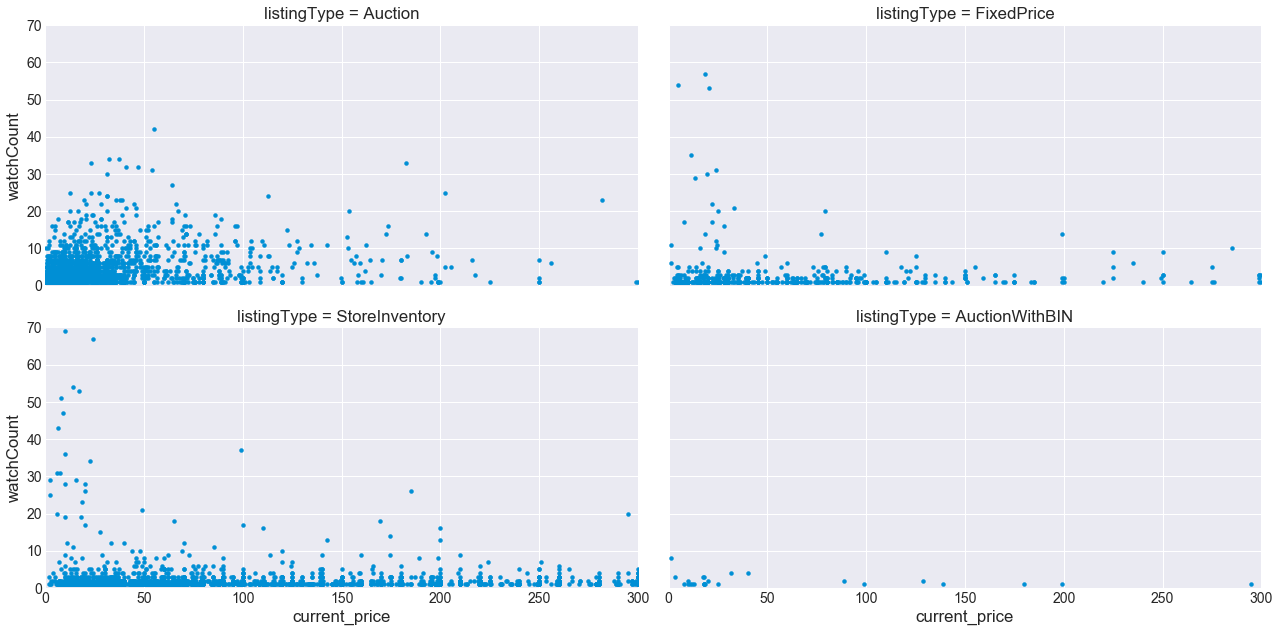

In [21]:
#what is the relationship between watchcount and current price? 
print('Number of Auctions by Listing Type', '\n', df['listingType'].value_counts())
df.pipe(sns.FacetGrid, col='listingType', col_wrap=2,
       aspect=2, size=4.5).map(plt.scatter, 'current_price',
                             'watchCount', s=15)
plt.ylim(0, 70)
plt.xlim(0, 300)
plt.tight_layout()

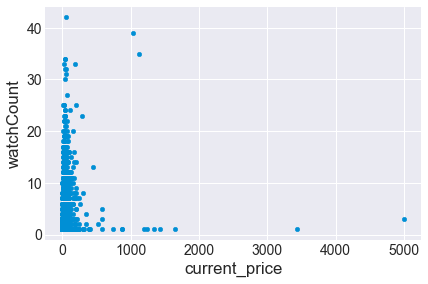

In [22]:
df.loc[df['listingType'] == 'Auction'].plot('current_price', 'watchCount', kind='scatter')

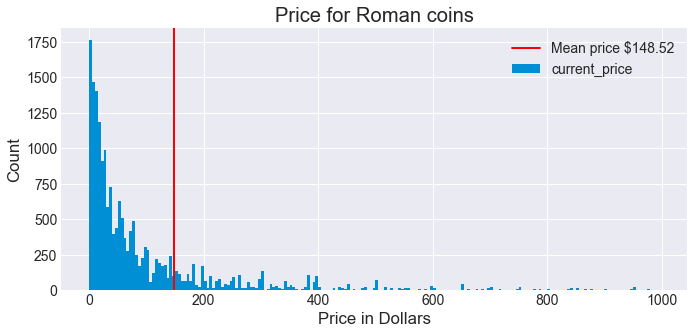

In [24]:
fig, ax = plt.subplots(figsize=(10, 4.5))
bins = np.arange(0, 1000, 5)
ax = ax.hist(df['current_price'], bins=bins)
plt.xlabel('Price in Dollars')
plt.ylabel('Count')
plt.title('Price for Roman coins')
plt.axvline(df['current_price'].mean(), lw=2, c='red', label = 'Mean price ${0:.2f}'.format(
                                                            df['current_price'].mean()))
plt.legend()

In [25]:
#A massive outlier, representing a rare coin of Emperor Caligula's sisters, with whom he was reported to have had an affair. 
df['current_price'].describe(percentiles =[0.25, 0.50, 0.75, 0.90, 0.95])

count    18961.000000
mean       148.524301
std        780.477051
min          0.010000
25%         15.300000
50%         45.000000
75%        120.000000
90%        295.000000
95%        469.000000
max      35750.000000
Name: current_price, dtype: float64

In [26]:
#206 coins have current_prices greater than 1000 dollars
len(list(df.loc[df['current_price'] > 1000].index))

242

In [27]:
df['shippingType'] = df['shippingType'].apply(lambda x: 'International' if x in ['CalculatedDomesticFlatInternational',
                                                                                'FlatDomesticCalculatedInternational'] else x)

Text(0.5,1,'Coin price by shipping type (Avg. shipping cost above)')

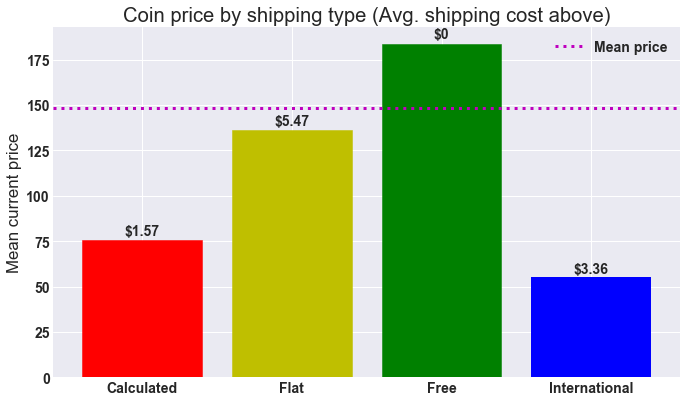

In [29]:
from matplotlib import rc

rc('font', weight='bold')
shipping_graph = df.groupby('shippingType', as_index=False)['current_price'].mean()
shipping_graph = shipping_graph.loc[shipping_graph['shippingType'].isin(['Calculated', 'Flat', 'Free', 'International'])]

avg_cost = ['$1.57', '$5.47', '$0', '$3.36']
fig, ax = plt.subplots(figsize=(10, 6))
barlist = plt.bar(shipping_graph['shippingType'], shipping_graph['current_price'], 
                  color='blue', )

barlist[0].set_color('r')
barlist[1].set_color('y')
barlist[2].set_color('g')
plt.axhline(df['current_price'].mean(), lw=3, c='m', ls='dotted', label='Mean price')
plt.ylabel('Mean current price')
for num,rect in enumerate(barlist):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                avg_cost[num],
                ha='center', va='bottom',)


plt.legend()
plt.title('Coin price by shipping type (Avg. shipping cost above)')

(0, 500)

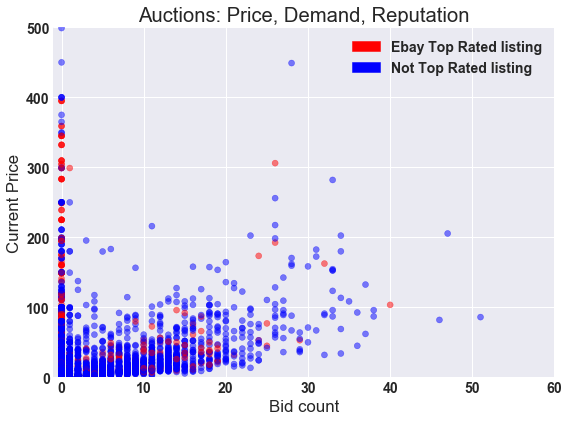

In [30]:
import matplotlib.patches as mpatches
auction_interest = df.loc[df['listingType'] == 'Auction']
rc('font', weight='bold')
plt.subplots(figsize=(8, 6))
plt.scatter(auction_interest['bidCount'], 
            auction_interest['current_price'], c=auction_interest['topRatedListing'].apply(
            lambda x: 'r' if x == 1 else 'b'), alpha=0.5)


legend_patch = mpatches.Patch(color='red', label='Ebay Top Rated listing')
legend_patch2 = mpatches.Patch(color='blue', label='Not Top Rated listing')                            
plt.legend(handles=[legend_patch, legend_patch2])

plt.title('Auctions: Price, Demand, Reputation')
plt.xlabel('Bid count')
plt.ylabel('Current Price')
plt.xlim(-1, 60)
plt.ylim(0, 500)

In [31]:
#pulling individual emperors from titles

#splitting and rejoining URLtitles
df['URLTitle'] = df['URLTitle'].str.split('-').apply(lambda x: " ".join(x))
df['URLTitle'] = df['URLTitle'].str.lower()

roman_emperors = ['Augustus', 'Tiberius', 'Caligula', 'Claudius', 'Nero', 'Galba', 'Otho', 'Aulus Vitellius', 'Vespasian', 'Titus', 
                  'Domitian', 'Nerva', 'Trajan', 'Hadrian', 'Antoninus Pius', 'Marcus Aurelius', 'Lucius Verus', 'Commodus', 'Publius Helvius Pertinax', 
                  'Marcus Didius Severus Julianus', 'Septimius Severus', 'Caracalla', 'Publius Septimius Geta', 'Macrinus', 'Elagabalus', 'Severus Alexander', 
                  'Maximinus', 'Gordian I', 'Gordian II', 'Pupienus Maximus', 'Balbinus', 'Gordian III', 'Philip', 'Decius', 'Hostilian', 'Gallus', 'Aemilian', 'Valerian', 'Gallienus', 
                  'Claudius II Gothicus', 'Quintillus', 'Aurelian', 'Tacitus', 'Florian', 'Probus', 'Carus', 'Numerian', 'Carinus', 'Diocletian', 'Maximian', 'Constantius I',
                  'Galerius',  'Constantine I ', 'Galerius Valerius Maximinus', 'Licinius', 'Constantine II ', 'Constantius II', 'Constans I', 'Gallus Caesar', 'Julian', 'Jovian', 
                  'Valentinian I', 'Valens', 'Gratian', 'Valentinian II', 'Theodosius I', 'Arcadius', 'Magnus Maximus', 'Honorius', 'Theodosius II', 'Constantius III', 'Valentinian III',
                  'Marcian', 'Petronius Maximus', 'Avitus', 'Majorian', 'Anthemius', 'Olybrius', 'Glycerius', 'Julius Nepos', 'Romulus Augustulus', 'Leo I', 'Leo II', 'Zeno']

roman_emperors = [x.lower() for x in roman_emperors]

emperors = []

for title in df['URLTitle']:
    if 'lot' in title: 
        emperors.append('LOT')
    else:
        emps = re.findall(r"(?=("+'|'.join(roman_emperors)+r"))",title)
        if emps:
            emperors.append(emps)
        else: 
            emperors.append('unknown')

df['emperor_in_title'] = emperors

In [32]:
#There are 891 lots (buzz word for multiple coins)
print('Number of lots: ', np.sum(df['emperor_in_title'] == 'LOT'))
print('Neither a lot nor an emperor: ', np.sum(df['emperor_in_title'] == 'unknown'))

Number of lots:  1537
Neither a lot nor an emperor:  7526


In [33]:
#Eliminating non-coin sales
posters = []

for num, val in enumerate(df['URLTitle']):
    if 'poster' in val:
        posters.append(num)

df = df.drop(posters, axis=0).reset_index(drop=True)


In [34]:
#Identifying whether there are one or more emperors in the title (i.e. is it one coin or more)
#creating separate columns for dummy variable creation later
singles = []
for num, val in enumerate(df['emperor_in_title']):
    if val != 'unknown':
        if len(val) > 1:
            singles.append('multiple_emps_in_title')
        elif len(val) == 1:
            singles.append(val[0])
    else:
        singles.append('unknown')
            
df['emp_prep_dummies'] = singles

In [35]:
#Extracting coin material from titles 
metals = ['gold', 'silver', 'bronze', 'orichalcum', 'copper']

metal = []
for title in df['URLTitle']:
    coin = re.findall(r"(?=("+'|'.join(metals)+r"))",title)
    if coin:
        metal.append(coin)
    else: 
        metal.append(['unknown'])
        
df['coin_metal'] = metal

In [36]:
def metal_cleaner(col):
    """Removes metal values from lists"""
    try:
        multi = ' '.join(col)
        return multi
    except:
        single = col[0]
        return single

df['coin_metal'] = df['coin_metal'].apply(metal_cleaner)

In [37]:
#365 observations include a jewelery keyword, dropping
jewelery = []

for num, val in enumerate(df['URLTitle']):
    if 'earring' in val:
        jewelery.append(num)
    elif 'pendant' in val:
        jewelery.append(num)
    elif 'bracelet'in val:
        jewelery.append(num)
    elif 'necklace' in val:
        jewelery.append(num)

df = df.drop(jewelery, axis=0).reset_index(drop=True)

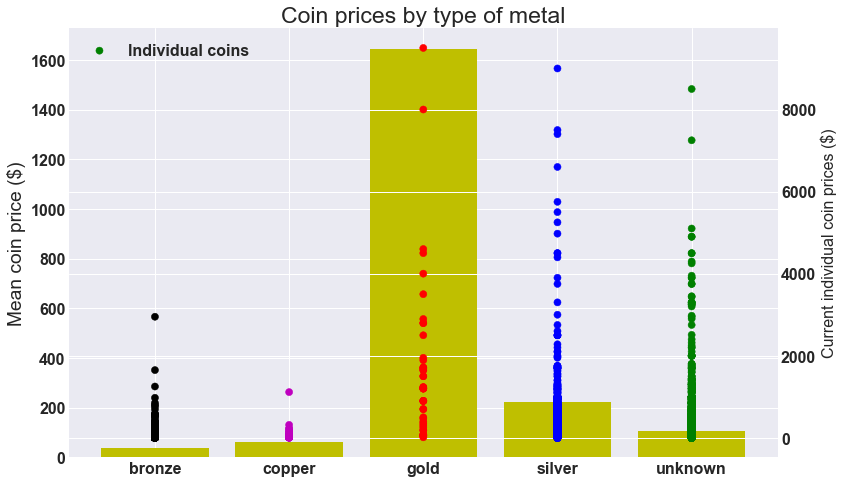

In [38]:
metal_graph = df[df['coin_metal'].isin(['gold', 'silver', 'bronze', 'copper', 'unknown'])].loc[df['current_price'] < 10000]
metal_graph2 = metal_graph.groupby('coin_metal', as_index=False)['current_price'].mean().sort_values(by=['current_price'])

rc('font', weight='bold', size=16)
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(metal_graph2['coin_metal'], metal_graph2['current_price'], color='y')
plt.ylabel('Mean coin price ($)')
ax2 = ax.twinx()
colors = {'gold':'r', 'silver':'b', 'bronze': 'k', 'copper': 'm', 'unknown': 'g'}
ax2.scatter(metal_graph['coin_metal'], metal_graph['current_price'], label='Individual coins',s=50, c=metal_graph['coin_metal'].map(colors))
plt.ylabel('Current individual coin prices ($)', size=16)
plt.title('Coin prices by type of metal')
plt.legend(loc=2)
fig.tight_layout()

In [39]:
def emperor_cleaner(col):
    """eliminating duplicate emperor names within same listing, making them strings"""   
    if col == 'unknown' or col == 'LOT':
        return col
    else:
        if len(col) > 1:
            emp = list(set(col))
            clean = ' '.join(emp)
            return clean
        elif len(col) == 1:
            emp = col[0]
            return emp

df['emperor_in_title'] = df['emperor_in_title'].apply(emperor_cleaner)

In [40]:
#Preparing data to examine price/availability by emperor/reign/time period

emperor_graph = df.groupby('emperor_in_title', as_index=False).agg({
    'current_price':['median','max','min'], 
    'autoPay': 'count'}).sort_values([('autoPay', 'count')]).reset_index(drop=True)

emperor_graph.columns = emperor_graph.columns.droplevel()
emperor_graph.columns = ['Emperor', 'Median price', 'Max price', 'Min price', 'Unique sales']


emperor_graph.loc[emperor_graph['Median price'] > 2000]

,Emperor,Median price,Max price,Min price,Unique sales
17,carus marcus aurelius,4000.0,4000.0,4000.0,1
33,antoninus pius trajan decius,2497.0,2497.0,2497.0,1
36,galba nero,9000.0,9000.0,9000.0,1


In [41]:
#dropping Nero Galba (1 sale, $22,500), carus marcus aurelius (1 sale, $4000)
#dropping lots and unknown values
emperor_graph = emperor_graph.drop(list(emperor_graph[emperor_graph['Emperor'].isin([
    'LOT','unknown', 'nero galba', 'carus marcus aurelius'])].index), axis=0)

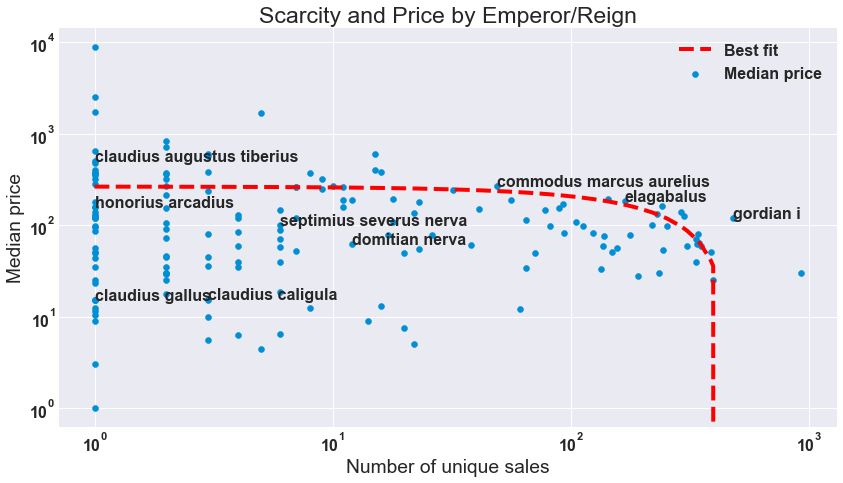

In [42]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(emperor_graph['Unique sales'], emperor_graph['Median price'])
plt.semilogy()
plt.semilogx()

for index, row in emperor_graph.iterrows():
    if index % 20 == 0:
        if row['Emperor'] != 'marcus aurelius hadrian':
            ax.annotate(row['Emperor'], (row['Unique sales'], row['Median price']))

#manually entered, reconfigure to make robust for new data
# ax.annotate('maximinus nerva', (1, 0.99))
# ax.annotate('aemilian', (3, 6500))
# ax.annotate('constantius i', (485, 30.11))

ax.plot(np.unique(emperor_graph['Unique sales']), 
         np.poly1d(np.polyfit(emperor_graph['Unique sales'], 
                              emperor_graph['Median price'], 1))
                 (np.unique(emperor_graph['Unique sales'])), c='r', linestyle='dashed', label='Best fit')
plt.ylabel('Median price')
plt.xlabel('Number of unique sales')
plt.title('Scarcity and Price by Emperor/Reign')
plt.legend()
plt.tight_layout()

In [43]:
#Adding dummies for gold and silver
df['gold'] = df['coin_metal'].apply(lambda x: 1 if x == 'gold' else 0)
df['silver'] = df['coin_metal'].apply(lambda x: 1 if x == 'silver' else 0 )

In [44]:
#Creating dummy variable for lots (i.e. more than 1 coin for sale)
df['is_a_lot'] = df['emperor_in_title'].apply(lambda x: 1 if x == 'LOT' else 0)

In [45]:
#uncleaned is a common indicator of low quality, creating dummy

uncleaned = []
for val in df['URLTitle']:
    has = re.search('uncleaned', val)
    if has:
        uncleaned.append(1)
    else:
        uncleaned.append(0)

df['uncleaned'] = uncleaned

In [46]:
#Creating total sale time feature, putting it into days
df['total_sale_time'] = df['endTime'] - df['startTime']
df['total_sale_time'] = df.total_sale_time.dt.days

#dropping lots that have negative total time values (likely put up and immediately 
#taken down)
df = df.drop(list(df.loc[df['total_sale_time'] < 0].index), axis=0)


#Creating categorical bins for duration
df['total_sale_time'] = pd.cut(df['total_sale_time'], 
           [0, 7, 30, 365, df['total_sale_time'].max()], 
          labels=['Less_than_week', 'Less_than_month', 'less_than_year', 'more_than_year'])

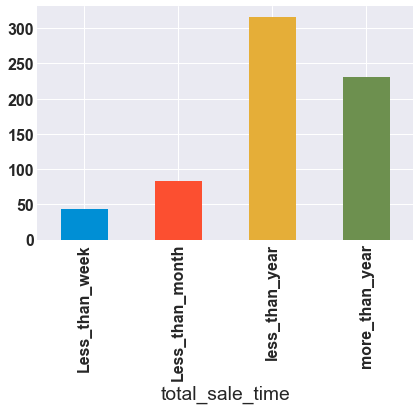

In [47]:
df.groupby('total_sale_time')['current_price'].mean().plot(kind='bar')
#creating dummies for sales period and merging with main df
df = pd.concat([df, pd.get_dummies(df['total_sale_time']).drop('less_than_year', 
                                                               axis=1)], axis=1 )
df = df.drop('total_sale_time', axis=1)

In [48]:
#Queens (zip: 11374) seems to house a professional high-volume seller, creating dummy
#41% of volume eminates from this zip
df['Queens_seller'] = df['postalCode'].apply(lambda x: 1 if x == '11374' else 0)
df = df.drop('postalCode', axis=1)

In [49]:
#what is the approximate value of items placed for bidding each week, how many bids per week,
#total 'value' for sale

for val in range(1, 5):
    x = '2018-2-' + str(16 + val)
    y = '2018-2-' + str(23 + val)
    time = df.loc[(df['startTime'] > x) & (df['startTime'] < y)]
    print('# items that start during week: ', len(time.index),
         'total value: ', time['current_price'].sum(), '\n', 'Number of bids per week: ',
         time.loc[time['listingType'] == 'Auction']['bidCount'].sum())

for val in range(1, 5):
    x = '2018-2-' + str(22 + val)
    y = '2018-3-' + str(1 + val)
    time = df.loc[(df['startTime'] > x) & (df['startTime'] < y)]
    print('# items that start during week: ', len(time.index),
         'total value: ', time['current_price'].sum(), '\n', 'Number of bids per week: ',
         (time.loc[time['listingType'] == 'Auction']['bidCount'].sum()))

# items that start during week:  2215 total value:  125866.21 
 Number of bids per week:  4617.0
# items that start during week:  2186 total value:  129879.18 
 Number of bids per week:  4529.0
# items that start during week:  2139 total value:  121775.59 
 Number of bids per week:  4586.0
# items that start during week:  1976 total value:  107267.64 
 Number of bids per week:  4638.0
# items that start during week:  1626 total value:  91332.84 
 Number of bids per week:  3285.0
# items that start during week:  1518 total value:  93677.42 
 Number of bids per week:  2916.0
# items that start during week:  1537 total value:  94786.38 
 Number of bids per week:  2879.0
# items that start during week:  1862 total value:  108322.18 
 Number of bids per week:  3425.0


In [50]:
#creating dummies based on 'quality' indications in the title
def low_quality(title):
    word = re.findall(r'low|lower', title)
    if word:
        return 1
    else:
        return 0

def high_quality(title):
    word = re.findall(r'high|higher|premium|rare', title)
    if word:
        return 1
    else:
        return 0
    
df['high_quality_words'] = df['URLTitle'].apply(high_quality)
df['low_quality_words'] = df['URLTitle'].apply(low_quality)

In [355]:
#this is code to examine common adjectives. 

# from collections import Counter

# words = []
# for val in df['URLTitle']:
#     tokens = nltk.word_tokenize(val)
#     tagged = nltk.pos_tag(tokens)
#     for word in tagged:
#         if word[1] == 'JJ':
#             words.append(word[0])
            
# Counter(words).most_common(50)

In [51]:
#1 represents NOT paypal
df.groupby('paymentMethod')['current_price'].mean()

paymentMethod
0    149.396984
1     71.345198
Name: current_price, dtype: float64

In [52]:
#turning shipping type into dummy variables
df = pd.concat([df, pd.get_dummies(df['shippingType']).drop([
                'International', 'FreePickup'], axis=1)], axis=1)

#dropping shipping_cost, shippingType
df = df.drop(['shipping_cost', 'shippingType'], axis=1)
#dropping location, productId
df = df.drop(['location', 'productId'], axis=1)
#perfectly correlated with current_price, dropping
df = df.drop('value_conv', axis=1)

In [53]:
#getting listing type dummies, 
df = pd.concat([df, pd.get_dummies(df['listingType']).drop(
            ['AuctionWithBIN', 'StoreInventory'], axis=1)], axis=1)
df = df.drop('listingType', axis=1)

#dropping start/endTime
df = df.drop(['endTime', 'startTime'], axis=1)

#dropping categoryId
df = df.drop('categoryId', axis=1)

In [54]:
#creating two more dummies for coin metals before dropping
df['bronze'] = df['coin_metal'].apply(lambda x: 1 if x == 'bronze' else 0)
df['copper'] = df['coin_metal'].apply(lambda x: 1 if x == 'copper' else 0)
df = df.drop('coin_metal', axis=1)

In [55]:
df['bidCount'] = df['bidCount'].fillna(0)
df['watchCount'] = df['watchCount'].fillna(0)

In [56]:
#adding the emperor dummy variables and concatting to main df
df = pd.concat([df, pd.get_dummies(df['emp_prep_dummies']).drop(
    'unknown', axis=1)], axis=1)

df = df.drop('emp_prep_dummies', axis=1)
df = df.drop('emperor_in_title', axis=1)

In [362]:
#the only remaining categories that need to be removed are itemId, and Url title
#I am going to test URL title as tfidf features, and I am going to save itemId to eliminate possible
#duplicates before predicting on future data. 

In [57]:
df.to_csv('model_data_2.csv')